# Making graphes for Matching Rate, Miss Rate, Mean IoU

In [331]:
import glob
import re
import natsort
import pandas as pd

In [512]:
results_dir = "."

#scale = "06"
#scale_str = "0.6-1.4(0.1 step)"
#scale = "07"
#scale_str = "0.7-1.3(0.075 step)"
#scale = "08"
#scale_str = "0.8-1.2(0.05 step)"
scale = "09"
scale_str = "0.9-1.1(0.025 step)"
#scale = "95"
#scale_str = "0.95-1.05(0.0125 step)"

all_models = ["dla34", "hourglass", "resdcn101", "ssd", "mtdssd"]
backbones = ["dla34", "hourglass", "resdcn101"]
batch_size = "30"
rate_columns = ['matching_rate', 'miss_rate', 'mean_iou']

In [513]:
dla_max_epoch = 920
dla_epochs = [ int(epoch) for epoch in range(200, int(dla_max_epoch)+1) \
               if (epoch % 100 == 0) or (epoch == int(dla_max_epoch))]

other_max_epoch = 560
other_epochs = [ int(epoch) for epoch in range(200, int(other_max_epoch)+1) \
                 if (epoch % 100 == 0) or (epoch == int(other_max_epoch))]

epochs = sorted(set(dla_epochs + other_epochs))

In [514]:
def fetch_rate(f):
    lines = f.readlines()
    rate = dict()
    for line in lines:
        if line.startswith("Matching Rate:"):
            rate['matching_rate'] = float(line.split(":")[1].strip()) * 100
        elif line.startswith("Miss(No detection box) Rate:"):
            rate['miss_rate'] = float(line.split(":")[1].strip()) * 100
        elif line.startswith("Mean IoU:"):
            rate['mean_iou'] = float(line.split(":")[1].strip()) * 100
        else:
            continue   
    return rate

In [515]:
df = dict()
for model in all_models:
    df[model] = pd.DataFrame(index=epochs, columns=rate_columns, dtype=float)

for model in all_models:
    if model == "ssd":
        ssd_rate = {'matching_rate': 87.94,
                    'miss_rate': 29.65,
                    'mean_iou': 81.05}
        for epoch in epochs:
            df[model].loc[epoch] = ssd_rate
        continue
    elif model == "mtdssd":
        mtdssd_rate = {'matching_rate': 92.83,
                       'miss_rate': 30.77,
                       'mean_iou': 83.00}
        for epoch in epochs:
            df[model].loc[epoch] = mtdssd_rate
        continue
        
    dir = glob.glob(f'{results_dir}/{scale}_{model}')
    if not dir or len(dir) == 0:
        print("list is empty")
        continue
    files = glob.glob(f'{dir[0]}/{scale}_{model}_bs{batch_size}_*.txt')
    for file in natsort.natsorted(files):
        with open(file) as f:
            tmp1 = re.search(r'_bs\d+', file)
            batch_size = int(tmp1[0][3:])
            tmp2 = re.search(r'_epoch\d+', file)
            epoch = int(tmp2[0][6:])
            rate = fetch_rate(f)
            df[model].loc[epoch] = rate
    print(df[model])

     matching_rate  miss_rate   mean_iou
200      90.952762  19.781631  87.480270
300      92.003231  20.437018  87.910317
400      91.155378  19.602819  87.694870
500      91.754244  20.552344  88.132616
560            NaN        NaN        NaN
600      91.774194  20.665387  88.160052
700      91.221069  20.038290  88.007629
800      91.485944  19.884170  88.030666
900      91.539081  20.295440  88.036477
920      91.366906  19.394330  88.056753
     matching_rate  miss_rate   mean_iou
200      81.648523  20.223325  88.187512
300      81.478599  20.235878  88.139649
400      82.171157  20.877743  88.383079
500      82.701422  20.726362  88.309990
560      82.246661  20.536829  88.396743
600            NaN        NaN        NaN
700            NaN        NaN        NaN
800            NaN        NaN        NaN
900            NaN        NaN        NaN
920            NaN        NaN        NaN
     matching_rate  miss_rate   mean_iou
200      73.137461  42.899940  87.047980
300      73.3067

         dla34  hourglass  resdcn101
200  90.952762  81.648523  73.137461
300  92.003231  81.478599  73.306773
400  91.155378  82.171157  73.689228
500  91.754244  82.701422  73.407202
560  91.774194  82.246661  74.930362
600  91.774194        NaN        NaN
700  91.221069        NaN        NaN
800  91.485944        NaN        NaN
900  91.539081        NaN        NaN
920  91.366906        NaN        NaN


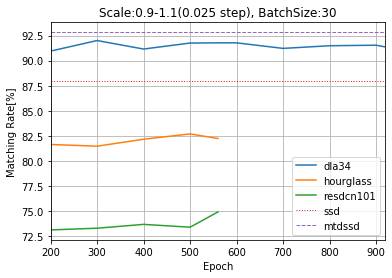

In [516]:
rate_column = 'matching_rate'
df_matching_rate = pd.concat([df['dla34'][rate_column],
                              df['hourglass'][rate_column],
                              df['resdcn101'][rate_column]],
                             axis=1, keys=backbones)
df_matching_rate.dropna(how='all', inplace=True)
df_matching_rate.fillna(method='bfill', inplace=True)
ax = df_matching_rate.plot(
    title=f'Scale:{scale_str}, BatchSize:{batch_size}',
    grid=True)
ax.plot(list(df['ssd'].index.values), list(df['ssd'][rate_column]),
        label='ssd', ls='dotted', linewidth=1)
ax.plot(list(df['mtdssd'].index.values), list(df['mtdssd'][rate_column]),
        label='mtdssd', ls='dashed', linewidth=1)
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Matching Rate[%]')
fig = ax.get_figure()
fig.savefig(f"{scale}_{batch_size}_matching_rate.png")
print(df_matching_rate)

         dla34  hourglass  resdcn101
200  19.781631  20.223325  42.899940
300  20.437018  20.235878  40.906416
400  19.602819  20.877743  38.294118
500  20.552344  20.726362  37.034884
560  20.665387  20.536829  36.120996
600  20.665387        NaN        NaN
700  20.038290        NaN        NaN
800  19.884170        NaN        NaN
900  20.295440        NaN        NaN
920  19.394330        NaN        NaN


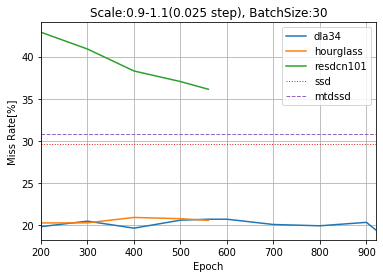

In [517]:
rate_column = 'miss_rate'
df_miss_rate = pd.concat([df['dla34'][rate_column],
                              df['hourglass'][rate_column],
                              df['resdcn101'][rate_column]],
                             axis=1, keys=backbones)
df_miss_rate.dropna(how='all', inplace=True)
df_miss_rate.fillna(method='bfill', inplace=True)
ax = df_miss_rate.plot(
    title=f'Scale:{scale_str}, BatchSize:{batch_size}',
    grid=True)
ax.plot(list(df['ssd'].index.values), list(df['ssd'][rate_column]),
        label='ssd', ls='dotted', linewidth=1)
ax.plot(list(df['mtdssd'].index.values), list(df['mtdssd'][rate_column]),
        label='mtdssd', ls='dashed', linewidth=1)
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Miss Rate[%]')
fig = ax.get_figure()
fig.savefig(f"{scale}_{batch_size}_miss_rate.png")
print(df_miss_rate)

         dla34  hourglass  resdcn101
200  87.480270  88.187512  87.047980
300  87.910317  88.139649  86.635026
400  87.694870  88.383079  86.272084
500  88.132616  88.309990  86.358296
560  88.160052  88.396743  86.127650
600  88.160052        NaN        NaN
700  88.007629        NaN        NaN
800  88.030666        NaN        NaN
900  88.036477        NaN        NaN
920  88.056753        NaN        NaN


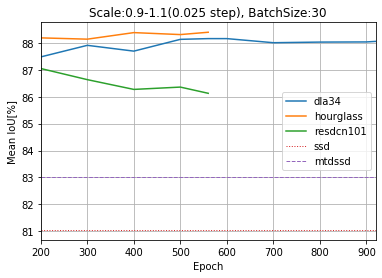

In [518]:
rate_column = 'mean_iou'
df_mean_iou = pd.concat([df['dla34'][rate_column],
                              df['hourglass'][rate_column],
                              df['resdcn101'][rate_column]],
                             axis=1, keys=backbones)
df_mean_iou.dropna(how='all', inplace=True)
df_mean_iou.fillna(method='bfill', inplace=True)
ax = df_mean_iou.plot(
    title=f'Scale:{scale_str}, BatchSize:{batch_size}',
    grid=True)
ax.plot(list(df['ssd'].index.values), list(df['ssd'][rate_column]),
        label='ssd', ls='dotted', linewidth=1)
ax.plot(list(df['mtdssd'].index.values), list(df['mtdssd'][rate_column]),
        label='mtdssd', ls='dashed', linewidth=1)
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean IoU[%]')
fig = ax.get_figure()
fig.savefig(f"{scale}_{batch_size}_mean_iou.png")
print(df_mean_iou)

# Finding the best score 

In [339]:
scales = ['06', '07', '09', '95']
backbones = ["dla34", "hourglass", "resdcn101"]
batch_sizes = [10, 15, 30, 43, 86]

matching_rate_max = {'rate': 0.0}
miss_rate_min = {'rate': 100.0}
mean_iou_max = {'rate': 0.0}

In [340]:
for scale in scales:
    for backbone in backbones:
        for batch_size in batch_sizes:
            dir = glob.glob(f'{results_dir}/{scale}_{backbone}')
            if not dir or len(dir) == 0:
                continue
            files = glob.glob(f'{dir[0]}/{scale}_{backbone}_bs{batch_size}_*.txt')
            for file in natsort.natsorted(files):
                with open(file) as f:
                    tmp1 = re.search(r'_bs\d+', file)
                    batch_size = int(tmp1[0][3:])
                    tmp2 = re.search(r'_epoch\d+', file)
                    epoch = int(tmp2[0][6:])
                    rate = fetch_rate(f)
                    if rate['matching_rate'] > matching_rate_max['rate']:
                        matching_rate_max['rate'] = rate['matching_rate']
                        matching_rate_max['scale'] = scale
                        matching_rate_max['backbone'] = backbone
                        matching_rate_max['batch_size'] = batch_size
                        matching_rate_max['epoch'] = epoch
                    if rate['miss_rate'] < miss_rate_min['rate']:
                        miss_rate_min['rate'] = rate['miss_rate']
                        miss_rate_min['scale'] = scale
                        miss_rate_min['backbone'] = backbone
                        miss_rate_min['batch_size'] = batch_size
                        miss_rate_min['epoch'] = epoch               
                    if rate['mean_iou'] > mean_iou_max['rate']:
                        mean_iou_max['rate'] = rate['mean_iou']
                        mean_iou_max['scale'] = scale
                        mean_iou_max['backbone'] = backbone
                        mean_iou_max['batch_size'] = batch_size
                        mean_iou_max['epoch'] = epoch               

print(f"matching_rate:{matching_rate_max}")
print(f"miss_rate:{miss_rate_min}")
print(f"mean_iou:{mean_iou_max}")

matching_rate:{'rate': 92.00323101777059, 'scale': '09', 'backbone': 'dla34', 'batch_size': 30, 'epoch': 300}
miss_rate:{'rate': 16.317460317460316, 'scale': '07', 'backbone': 'dla34', 'batch_size': 30, 'epoch': 200}
mean_iou:{'rate': 89.37945177151846, 'scale': '09', 'backbone': 'hourglass', 'batch_size': 10, 'epoch': 500}
